In [23]:
#Equação de Schrondinger para duas partículas

#Danilo Lessa Bernardineli
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integ
from ipywidgets import widgets

/usr/local/lib/python3.4/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [11]:
### Parâmetros das condições iniciais ###
x1_c = -0.2
s1 = 0.05
k1_0 = 30
m1 = 1

x2_c = 0.3
s2 = 0.10
k2_0 = 20
m2 = 2

#Parâmetros do potencial barreira
V_0 = 0
x1 = 0
x2 = 0

### Parâmetros de simulação ###

#Intervalo no eixo x
x_i = -1
x_f = 1

#Intervalo temporal
t_0 = 0
t_f = 0.001

#Passos
dt = 0.0001
r = 0.075
dx = np.sqrt(dt / (2 * r))
dx2 = 2 * dx ** 2

#Tamanho das matrizes de simulação
Nt = int((t_f - t_0) / dt)
Nx = int((x_f - x_i) / dx)

#Discretização do espaço contínuo
Td = np.arange(Nt)
Xd = np.arange(Nx)
Yd = np.arange(Nx)

#Representação no espaço contínuo
T = Td * dt
X = (Xd * dx) + x_i
Y = (Yd * dx) + x_i

In [12]:
### Funções da simulação ###

def V(i):
    """Potential function for using in the simulation.
    Keyword arguments:
    i -- Potential in the i array position"""
    x = x_i + i * dx
    if x > x1 and x < x2:
        return V_0
    else:
        return 0   

def waveFunction1(x):
    """Initial time-indepedent wavefunction.
    Keyword arguments:
    x -- Wavefunction on the x position
    """
    expoent = (-1/2) * (((x - x1_c) / s1)) ** 2
    return np.exp(1j * k1_0 * x) * np.sqrt(np.exp(expoent) / (s1 * np.sqrt(2 * np.pi)))

def waveFunction2(x):
    """Initial time-indepedent wavefunction.
    Keyword arguments:
    x -- Wavefunction on the x position
    """
    expoent = (-1/2) * (((x - x2_c) / s2)) ** 2
    return np.exp(1j * k2_0 * x) * np.sqrt(np.exp(expoent) / (s2 * np.sqrt(2 * np.pi)))

def der_R2(i, j, R, I):
    return der_R(i, I.T[j]) / m1  + der_R(j, I[i]) / m2

def der_I2(i, j, R, I):
    return der_I(i, R.T[j]) / m1 + der_I(j, R[i]) / m2


def der_R(i, I):
    """Get the real part of the wavefunction derivative."""
    if i == 0:
        return (2*I[i] - I[i+1]) / (dx2)
    elif i >= len(I) - 1:
        return (2*I[i] - I[i-1]) / (dx2)    
    else:
        return (2*I[i] - I[i+1] - I[i-1]) / (dx2)

def der_I(i, R):
    if i == 0:
        return ( R[i+1] - 2*R[i]) / (dx2)
    elif i >= len(R) - 1:
        return ( R[i-1] - 2*R[i]) / (dx2)
    else:
        return ( R[i+1] + R[i-1] - 2*R[i]) / (dx2)    
    
def HR(i, j, R):
    """Real part of the hamiltonian"""
    if i == 0:
        return -( R[i+1] - 2*R[i]) / (dx2) + V(i) * R[i]
    elif i >= len(R) - 1:
        return -( R[i-1] - 2*R[i]) / (dx2) + V(i) * R[i]
    else:
        return -( R[i+1] + R[i-1] - 2*R[i]) / (dx2) + V(i) * R[i]
    
def HI(i, j, I):
    """Imaginary part of the hamiltonian"""
    if i == 0:
        return (2*I[i] - I[i+1]) / (dx2) + V(i) * I[i]
    elif i >= len(I) - 1:
        return (2*I[i] - I[i-1]) / (dx2) + V(i) * I[i]    
    else:
        return (2*I[i] - I[i+1] - I[i-1]) / (dx2) + V(i) * I[i]

In [13]:
### Inicialização ###
res_R = np.zeros((Nt, Nx, Nx))
res_I = np.zeros((Nt, Nx, Nx))
res_HR = np.zeros((Nt, Nx, Nx))
res_HI = np.zeros((Nt, Nx, Nx))
res_N = np.zeros((Nt, Nx, Nx)) #Diferencial de Norma
norma = np.zeros(Nt) #Norma antes da renormalização
w1 = waveFunction1(X)
w2 = waveFunction2(Y)
W = np.zeros((Nx, Nx), dtype=np.complex_)
for i in Xd:
    for j in Yd:
        W[i][j] = w1[i] + w2[j]
res_R[0] = np.real(W)
res_I[0] = np.imag(W)

In [14]:
### Resolução númerica ###
#Renormalização
t = 0
for x in Xd:
    for y in Yd:
        res_N[t, x, y] = np.sqrt(res_R[t, x, y] ** 2 + res_I[t, x, y] ** 2) * dx * dx
norma[t] = np.sum(res_N[t])
res_R[t] = res_R[t] / norma[t]
res_I[t] = res_I[t] / norma[t]
norma[t] = 1

#Resolução da função de onda por RK2
for t in Td:
    
    if t == 0:
        continue 
        
    #Listas contendo os valores de meio-intervalo para o RK2
    half_R = np.zeros((Nx, Nx))
    half_I = np.zeros((Nx, Nx)) 
    
    #Primeira parte do RK2 - aproximando a função em meio passo
    for x in Xd:
        for y in Yd:
            #Valor da parte real e imaginária da função de onda em t-1
            x0_r = res_R[t - 1, x, y]
            x0_i = res_I[t - 1, x, y]

            #Derivadas das partes real e imaginária em t-1
            k1_r = der_R2(x, y, res_R[t - 1], res_I[t - 1]) * dt
            k1_i = der_I2(x, y, res_R[t - 1], res_I[t - 1]) * dt

            #Aproximação para a parte real e imaginária em t = (t - [t-1])/2
            x1_r = x0_r + k1_r / 2
            x1_i = x0_i + k1_i / 2

            #Armazenando o resultado acima
            half_R[x, y] = x1_r
            half_I[x, y] = x1_i
    
    #Segunda parte do RK2
    for x in Xd:
        for y in Yd:
            #Derivada das partes real e imaginária em (t - [t-1])/2
            k2_r = der_R2(x, y, half_R, half_I) * dt
            k2_i = der_I2(x, y, half_R, half_I) * dt

            #Armazenando a aproximação para a parte real e imaginária em t
            res_R[t, x, y] = res_R[t - 1, x, y] + k2_r
            res_I[t, x, y] = res_I[t - 1, x, y] + k2_i
        
    #Renormalização
    for x in Xd:
        for y in Yd:
            res_N[t, x, y] = np.sqrt(res_R[t, x, y] ** 2 + res_I[t, x, y] ** 2) * dx * dx
    norma[t] = np.sum(res_N[t])
    

In [15]:
W = res_R + 1j * res_I
Wabs = np.abs(W)

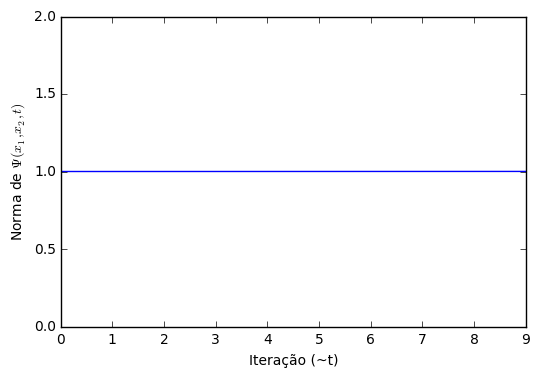

In [16]:
plt.plot(Td, norma)
plt.ylabel("Norma de $\Psi(x_1, x_2, t)$")
plt.xlabel("Iteração (~t)")
plt.ylim((0, 2))
plt.show()

In [21]:
#@widgets.interact(t=(0, W.shape[0]-1))
def plot_interactive(t):
    plt.imshow(Wabs[t], extent=[-1, 1, 1, -1])
    plt.colorbar()
    plt.title("Função de onda conjunta $\Psi(x_1, x_2, t)$")
    plt.xlabel("$\phi(x_2)$")
    plt.ylabel("$\phi(x_1)$")
    plt.show()

In [24]:
t = 9
plot_interactive(t)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>